# Shift fit obs data global: develop code 

Note - probably will have to redo my analyses on 2023 temperatures and data !! 

Limitation - only having obs data to 2019 and inferring relationships from this

Pro - ISIMIP3a consistency?


In [1]:
# output best estimate of each of the params

# and bootstrapped ensemble for each parameter? or just resulting 95% CI 

# test on a small square of DataArray 

# run with variable loc and with variable loc and scale

# one model per month 

# then ufunc it 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, 
# statsmodels, seaborn

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [5]:
from scipy import stats
#import seaborn as sns

#import corner # installed in myenv - not used 
import statsmodels.api as sm 

sys.path.append('../dist_cov/dist_cov/')
import distributions_dev as distributions
#import sample as sample
import utils as utils 

In [6]:
start_message() 

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'TX99', 'method': 'empirical_percentile', 'time_method': 'single-year', 'shift_sigma': None, 'shift_period': None, 'chunk_version': 2, 'var': 'tasmax'}
var: tasmax
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc1041

# open data & test fit on a pixel

In [7]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

,gmst
year,
1850,-0.043519
1851,0.032947
1852,0.066480
1853,0.059362
1854,0.050768
...,...
2018,1.176428
2019,1.212890
2020,1.212564


In [8]:
variable='wbgt'
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!

GCM = datasets[0]

dir1=os.path.join(scratchdirs, dirname, 'WBGT', 'ISIMIP3a', 'obsclim', GCM ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)


with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    lat, lon = 28,77
    da_delhi = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()
   

In [7]:
param_names, arr_params = norm_shift_fit(da_delhi, gmst_smo, shift_sigma=False)

In [8]:
param_names, arr_params

# turn into a single array?? or not...

(['b0', 'b1', 'sigma'],
 array([[ 1.70882863e+01,  2.10760030e-01,  1.80954773e+00],
        [ 1.85787287e+01,  1.22614949e+00,  2.35512045e+00],
        [ 2.24800340e+01,  1.22080562e+00,  2.53907429e+00],
        [ 2.60857144e+01,  5.60668601e-01,  2.35275603e+00],
        [ 2.90662827e+01,  3.48502920e-01,  2.37714533e+00],
        [ 3.12459334e+01, -1.29661167e-02,  1.92404311e+00],
        [ 3.05520883e+01,  4.95361025e-01,  1.71207578e+00],
        [ 2.95138376e+01,  8.35784742e-01,  1.29064682e+00],
        [ 2.87951698e+01,  1.05759411e+00,  1.66855712e+00],
        [ 2.63407130e+01,  8.66467340e-01,  2.15683036e+00],
        [ 2.17866981e+01,  1.43678808e+00,  1.88400732e+00],
        [ 1.80051594e+01,  8.51489406e-01,  1.95125362e+00]]))

# Testing on a square

In [9]:
## test fit on a data array square 

with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    da_sel = ds[str(variable)].sel(lat=slice(29,25), lon=slice(77,88)).chunk({'time': -1}).compute()


In [13]:
da_sel

<xarray.DataArray 'wbgt' (time: 43464, lat: 8, lon: 22)>
array([[[16.746763 , 16.278513 , 16.594646 , ...,  9.363566 ,
          9.58675  , 10.609076 ],
        [16.66319  , 16.394527 , 16.300135 , ..., 11.141367 ,
         10.844868 , 10.30026  ],
        [16.47077  , 16.570433 , 16.609547 , ..., 11.819951 ,
         10.796205 , 11.170695 ],
        ...,
        [17.676966 , 17.351404 , 16.851421 , ..., 15.979326 ,
         15.65767  , 15.680369 ],
        [17.810947 , 17.33597  , 16.972443 , ..., 16.041695 ,
         15.507654 , 15.985215 ],
        [18.312902 , 17.926237 , 17.358582 , ..., 16.14108  ,
         15.6219425, 16.32036  ]],

       [[16.95652  , 16.643953 , 16.866428 , ...,  8.824012 ,
          9.282545 , 10.086119 ],
        [16.832773 , 16.686005 , 16.714773 , ..., 10.033601 ,
          9.53595  ,  9.33798  ],
        [16.555702 , 16.927738 , 16.978764 , ..., 10.96354  ,
          9.666625 , 10.56936  ],
...
        [13.86361  , 13.655069 , 12.881291 , ..., 16.81202  ,
         17.411846 , 17.90268  ],
        [15.201305 , 14.685799 , 13.336118 , ..., 16.451317 ,
         17.188437 , 17.698048 ],
        [15.999586 , 15.537346 , 14.539154 , ..., 16.120445 ,
         16.652456 , 17.761965 ]],

       [[13.2903   , 13.958975 , 15.089676 , ...,  8.741483 ,
          9.358439 , 10.129406 ],
        [12.386272 , 13.69261  , 14.344156 , ...,  9.251303 ,
          9.440062 ,  9.250056 ],
        [12.458588 , 13.56167  , 14.102413 , ..., 11.808417 ,
         11.398525 , 11.775502 ],
        ...,
        [14.408483 , 14.180912 , 13.664246 , ..., 18.678421 ,
         18.661257 , 18.875814 ],
        [15.368077 , 14.4691925, 13.466782 , ..., 18.777426 ,
         18.859385 , 19.06361  ],
        [15.825835 , 14.983215 , 14.12595  , ..., 18.414505 ,
         18.614765 , 19.441444 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 ... 86.25 86.75 87.25 87.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25 26.75 26.25 25.75 25.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

## Do with loop over lat, lon

In [25]:

def norm_shift_fit_loop(da, df_cov, shift_sigma=False):
    """
    Fit normal distribution with shift fit (varying location or location and scale) as linear functions of a covariate
    Fit a different model for each month of the year 
    Best estimates with max likelihood estimation
    Uses fxns from dist_cov (Hauser et al, ETH) 
    
    Input : 
    
    da : your data as a dataarray
    df_cov : your covariate as an annual dataframe
    shift_sigma :   False: loc = b0 +b1*cov, scale fixed
                    True: loc = b0 +b1*cov, scale = sigma_b0 + sigma_b1*cov 
                    
    Returns:
    
    param names, param values  
                
    """
    
    arr_params = []
    
#     # loop over months
#     for j in range(1,13):
        
#         da_sel = da.sel(time=da['time.month'].isin([j]))
        
    da_sel = da

    t = da_sel.time.dt.year
    cov = df_cov.loc[t.values].values.squeeze()

    if len(da_sel.shape) == 3: #time,lat,lon

        for i in da_sel.lat:
            for k in da_sel.lon:

                x = da_sel.sel(lat=i,lon=k).values

                if shift_sigma==False:

                    dist = distributions.norm_cov(data=x, cov=cov)

                else: 

                    dist = distributions.norm_cov_std(data=x, cov=cov)

                params_mle = dist.fit()

                arr_params.append(params_mle)
    
    return dist.param_names, np.array(arr_params)

In [27]:
norm_shift_fit_loop(da_sel, gmst_smo, shift_sigma=False)

(['b0', 'b1', 'sigma'],
 array([[24.89745468,  0.88060658,  5.19534157],
        [25.27251036,  1.01872031,  5.24103761],
        [25.17873877,  1.11681037,  5.25126031],
        [25.20650303,  1.10228359,  5.23715261],
        [25.1508017 ,  1.16029212,  5.16963753],
        [25.21805801,  1.19287042,  5.17312595],
        [25.30386638,  1.17758817,  5.19589863],
        [25.32782287,  1.14144567,  5.13613017],
        [25.3561949 ,  1.16100049,  5.04818235],
        [25.4386979 ,  1.16666936,  4.90671298],
        [25.24869495,  1.11253716,  4.86570805],
        [25.03505119,  1.05096186,  4.77165939],
        [24.58515953,  1.06886318,  4.59044293],
        [24.82613293,  1.08479743,  4.58474849],
        [24.75898353,  1.07349478,  4.73299465],
        [24.78365168,  1.07756368,  4.75175844],
        [23.42322442,  1.03460508,  4.65308098],
        [20.52532166,  1.01551483,  4.6389283 ],
        [19.91567154,  0.97782849,  4.56954648],
        [17.73245413,  0.88933855,  4.3510575

# Try applying ufunc

In [71]:



def norm_shift_fit(da, df_cov, shift_sigma=False, by_month=False):
    """
    Fit normal distribution with shift fit (varying location or location and scale) as linear functions of a covariate
    Fit a different model for each month of the year 
    Best estimates with max likelihood estimation
    Uses functions from dist_cov (Hauser et al, ETH) 
    
    Input : 
    da : your data as a dataarray
    df_cov : your covariate as an annual dataframe
    shift_sigma :   False: loc = b0 + b1 * cov, scale fixed
                    True: loc = b0 + b1 * cov, scale = sigma_b0 + sigma_b1 * cov 
                    
    Returns:
    param names, param values  
    """
    
    def fit_normal_dist(data, covariate, shift_sigma):
        """Fit normal distribution to data with covariate."""
        if shift_sigma:
            dist = distributions.norm_cov_std(data=data, cov=covariate)
        else:
            dist = distributions.norm_cov(data=data, cov=covariate)
        return dist.fit()
    
    # if by_month da_sel = da.groupby... 
    da_sel = da

    t = da_sel.time.dt.year
    cov = df_cov.loc[t.values].values.squeeze()

    # Apply the fitting function across lat and lon dimensions
    result = xr.apply_ufunc(
        fit_normal_dist,
        da_sel,
        cov,
        shift_sigma,
        input_core_dims=[['time'], ['time'], []],
        output_core_dims=[['params']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    # rename params coordinates
    if shift_sigma:
        result['params'] = ["b0", "b1", "sigma_b0", "sigma_b1"]
    else:
        result['params'] = ["b0", "b1", "sigma"] 

    # rename variable
    result = result.rename('fit_params')
    
    return result

# Example usage (assuming 'da' is your DataArray and 'df_cov' is your DataFrame)
# param_names, params = norm_shift_fit_apply(da, df_cov, shift_sigma=False)


In [72]:
da_params = norm_shift_fit(da_sel, gmst_smo, shift_sigma=False)

In [73]:
da_params

<xarray.DataArray 'fit_params' (lat: 12, lon: 22, params: 3)>
array([[[24.89745468,  0.88060658,  5.19534157],
        [25.27251036,  1.01872031,  5.24103761],
        [25.17873877,  1.11681037,  5.25126031],
        [25.20650303,  1.10228359,  5.23715261],
        [25.1508017 ,  1.16029212,  5.16963753],
        [25.21805801,  1.19287042,  5.17312595],
        [25.30386638,  1.17758817,  5.19589863],
        [25.32782287,  1.14144567,  5.13613017],
        [25.3561949 ,  1.16100049,  5.04818235],
        [25.4386979 ,  1.16666936,  4.90671298],
        [25.24869495,  1.11253716,  4.86570805],
        [25.03505119,  1.05096186,  4.77165939],
        [24.58515953,  1.06886318,  4.59044293],
        [24.82613293,  1.08479743,  4.58474849],
        [24.75898353,  1.07349478,  4.73299465],
        [24.78365168,  1.07756368,  4.75175844],
        [23.42322442,  1.03460508,  4.65308098],
        [20.52532166,  1.01551483,  4.6389283 ],
        [19.91567154,  0.97782849,  4.56954648],
        [17.73245413,  0.88933855,  4.35105758],
...
        [24.75657132,  1.09074464,  3.50187675],
        [24.3898203 ,  1.02129205,  3.45729298],
        [24.91820471,  0.91318322,  3.47794882],
        [25.60548415,  0.85304415,  3.56933318],
        [25.93726726,  0.80112566,  3.69908588],
        [25.45936273,  0.7869549 ,  3.67582558],
        [25.61439338,  0.76603845,  3.6698966 ],
        [25.7435211 ,  0.77869888,  3.75816493],
        [25.66464824,  0.81371444,  3.89968741],
        [25.73043757,  0.83626424,  4.00582982],
        [25.35719941,  0.81841478,  4.19536699],
        [25.30716543,  0.85849219,  4.25982593],
        [25.46384261,  0.90842365,  4.33304148],
        [25.88667344,  0.95827773,  4.3502781 ],
        [25.32309679,  1.0331044 ,  4.22430408],
        [25.79415527,  1.02214987,  4.21196028],
        [25.91531057,  1.0607592 ,  4.21536241],
        [26.25212695,  1.06256543,  4.24047291],
        [26.27641466,  1.07255932,  4.19863852],
        [26.35771361,  1.04454971,  4.03326235]]])
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 ... 86.25 86.75 87.25 87.75
  * lat      (lat) float32 27.75 27.25 26.75 26.25 ... 23.75 23.25 22.75 22.25
  * params   (params) <U5 'b0' 'b1' 'sigma'

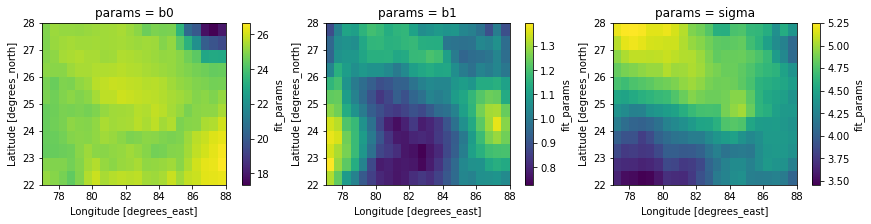

In [74]:
fig, axes = plt.subplots(1,3,figsize=(12,3), layout='constrained')

da_params.isel(params=0).plot(ax=axes[0])
da_params.isel(params=1).plot(ax=axes[1])
da_params.isel(params=2).plot(ax=axes[2])

## include possibility to do per month

In [95]:
import xarray as xr
import numpy as np
from dist_cov import distributions  # Assuming this is where your distributions are coming from

def norm_shift_fit(da, df_cov, shift_sigma=False, by_month=False):
    """
    Fit normal distribution with shift fit (varying location or location and scale) as linear functions of a covariate
    Fit a different model for each month of the year 
    Best estimates with max likelihood estimation
    Uses functions from dist_cov (Hauser et al, ETH) 
    
    Input : 
    da : your data as a dataarray
    df_cov : your covariate as an annual dataframe
    shift_sigma :   False: loc = b0 + b1 * cov, scale fixed
                    True: loc = b0 + b1 * cov, scale = sigma_b0 + sigma_b1 * cov 
    by_month : Boolean, if True, fit model for each month separately
                    
    Returns:
    DataArray with parameter names and values, and month as a coordinate if by_month is True.
    """
    
    def fit_normal_dist(data, covariate, shift_sigma):
        """Fit normal distribution to data with covariate."""
        if shift_sigma:
            dist = distributions.norm_cov_std(data=data, cov=covariate)
        else:
            dist = distributions.norm_cov(data=data, cov=covariate)
        return dist.fit()
    
    def apply_fit_to_group(da_group):
        """Apply the fitting function to a group of data."""
        t = da_group.time.dt.year
        cov = df_cov.loc[t.values].values.squeeze()

        result = xr.apply_ufunc(
            fit_normal_dist,
            da_group,
            cov,
            shift_sigma,
            input_core_dims=[['time'], ['time'], []],
            output_core_dims=[['params']],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float]
        )
        
        return result
    
    if by_month:
        results = []
        for month, group in da.groupby("time.month"):
            fit_result = apply_fit_to_group(group)
            fit_result = fit_result.expand_dims("month").assign_coords(month=("month", [month]))
            results.append(fit_result)
        
        result = xr.concat(results, dim="month")
    else:
        result = apply_fit_to_group(da)

    # Rename params coordinates
    if shift_sigma:
        result['params'] = ["b0", "b1", "sigma_b0", "sigma_b1"]
    else:
        result['params'] = ["b0", "b1", "sigma"]

    result = result.rename('fit_params')
    
    return result

# Example usage
# param_names, params = norm_shift_fit(da, df_cov, shift_sigma=False, by_month=True)


In [8]:
# smaller for testing

da_slice = da_sel.sel(lon=slice(77,80),lat=slice(29,27))

In [9]:
da_slice

<xarray.DataArray 'wbgt' (time: 43464, lat: 4, lon: 6)>
array([[[16.746763 , 16.278513 , 16.594646 , 16.379639 , 16.053669 ,
         15.49164  ],
        [16.66319  , 16.394527 , 16.300135 , 16.189098 , 16.399475 ,
         15.744688 ],
        [16.47077  , 16.570433 , 16.609547 , 16.553854 , 16.693203 ,
         16.075975 ],
        [16.474964 , 16.625715 , 16.849113 , 16.926195 , 16.781065 ,
         16.599537 ]],

       [[16.95652  , 16.643953 , 16.866428 , 16.576931 , 15.717508 ,
         15.179502 ],
        [16.832773 , 16.686005 , 16.714773 , 16.618578 , 16.153011 ,
         15.363787 ],
        [16.555702 , 16.927738 , 16.978764 , 17.026836 , 16.689453 ,
         16.17062  ],
        [16.916939 , 17.107828 , 17.286432 , 17.356916 , 17.126997 ,
         16.805841 ]],

       [[17.266262 , 16.313671 , 16.3582   , 16.053005 , 15.427953 ,
         15.175112 ],
...
        [12.61764  , 13.525734 , 13.328407 , 13.492656 , 13.384918 ,
         13.396881 ]],

       [[12.19009  , 12.557875 , 12.825402 , 13.251875 , 13.843859 ,
         14.170874 ],
        [11.634802 , 12.214011 , 12.537386 , 12.548437 , 12.94991  ,
         13.246697 ],
        [11.515784 , 11.783215 , 11.946085 , 12.413618 , 12.525193 ,
         12.670409 ],
        [11.587956 , 11.539755 , 11.715914 , 11.963463 , 12.369467 ,
         12.456682 ]],

       [[13.2903   , 13.958975 , 15.089676 , 15.788637 , 16.228321 ,
         16.863237 ],
        [12.386272 , 13.69261  , 14.344156 , 14.643318 , 15.29097  ,
         15.915262 ],
        [12.458588 , 13.56167  , 14.102413 , 14.47821  , 14.9067745,
         15.222217 ],
        [12.599834 , 13.421825 , 14.102418 , 14.3491535, 14.558687 ,
         15.080349 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

In [10]:
da_params_bymonth = norm_shift_fit(da_slice, gmst_smo, shift_sigma=True, by_month=True)

test: dask parallelized


In [11]:
da_params_bymonth

<xarray.DataArray 'fit_params' (month: 12, lat: 4, lon: 6, params: 4)>
array([[[[ 1.70682792e+01,  7.39357438e-02,  1.59509116e+00,
           5.30765819e-01],
         [ 1.69384839e+01,  2.50596397e-01,  1.58490417e+00,
           4.92745429e-01],
         [ 1.69348892e+01,  4.72601924e-01,  1.55409321e+00,
           4.86459448e-01],
         [ 1.68845065e+01,  5.94132371e-01,  1.57962623e+00,
           4.25490367e-01],
         [ 1.68290420e+01,  8.40302525e-01,  1.56467161e+00,
           3.52522383e-01],
         [ 1.68919887e+01,  9.38501532e-01,  1.51796257e+00,
           3.16924497e-01]],

        [[ 1.71098404e+01,  1.48229687e-01,  1.60459084e+00,
           5.34011996e-01],
         [ 1.71998880e+01,  2.50248150e-01,  1.62946741e+00,
           4.61614803e-01],
         [ 1.70743969e+01,  4.72761075e-01,  1.67167573e+00,
           4.11639776e-01],
         [ 1.71226059e+01,  5.90056394e-01,  1.67696101e+00,
...
           4.89501387e-01],
         [ 1.80831174e+01,  1.52157520e+00,  1.65715146e+00,
           4.85110783e-01],
         [ 1.80052992e+01,  1.72820690e+00,  1.59578486e+00,
           5.07864213e-01],
         [ 1.80172332e+01,  1.92127004e+00,  1.53393408e+00,
           5.45451764e-01]],

        [[ 1.82036000e+01,  1.18880096e+00,  1.71102907e+00,
           5.05655800e-01],
         [ 1.82577877e+01,  1.30806838e+00,  1.70070579e+00,
           5.11974298e-01],
         [ 1.82742183e+01,  1.41645446e+00,  1.65790930e+00,
           5.37756331e-01],
         [ 1.83702899e+01,  1.48115133e+00,  1.64423104e+00,
           5.31956436e-01],
         [ 1.83400418e+01,  1.65001205e+00,  1.60508689e+00,
           5.32782214e-01],
         [ 1.82113332e+01,  1.82382754e+00,  1.57143032e+00,
           5.27841783e-01]]]])
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) <U8 'b0' 'b1' 'sigma_b0' 'sigma_b1'

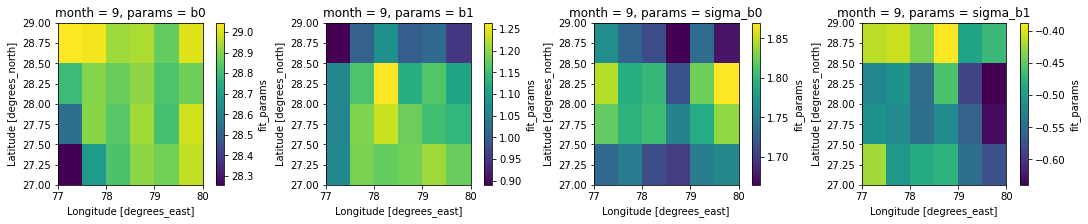

In [16]:
fig, axes = plt.subplots(1,4,figsize=(15,3), layout='constrained')

da_params_bymonth.isel(params=0, month=8).plot(ax=axes[0])
da_params_bymonth.isel(params=1, month=8).plot(ax=axes[1])
da_params_bymonth.isel(params=2, month=8).plot(ax=axes[2])
da_params_bymonth.isel(params=3, month=8).plot(ax=axes[3])

In [115]:
lat_delhi, lon_delhi = 28.25,77.25
da_params_bymonth.sel(lat=lat_delhi, lon=lon_delhi,method='nearest')

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[ 1.70882863e+01,  2.10760030e-01,  1.80954773e+00],
       [ 1.85787287e+01,  1.22614949e+00,  2.35512045e+00],
       [ 2.24800340e+01,  1.22080562e+00,  2.53907429e+00],
       [ 2.60857144e+01,  5.60668601e-01,  2.35275603e+00],
       [ 2.90662827e+01,  3.48502920e-01,  2.37714533e+00],
       [ 3.12459334e+01, -1.29661167e-02,  1.92404311e+00],
       [ 3.05520883e+01,  4.95361025e-01,  1.71207578e+00],
       [ 2.95138376e+01,  8.35784742e-01,  1.29064682e+00],
       [ 2.87951698e+01,  1.05759411e+00,  1.66855712e+00],
       [ 2.63407130e+01,  8.66467340e-01,  2.15683036e+00],
       [ 2.17866981e+01,  1.43678808e+00,  1.88400732e+00],
       [ 1.80051594e+01,  8.51489406e-01,  1.95125362e+00]])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) <U5 'b0' 'b1' 'sigma'

# To do: 

- run on all grid cells global (submit as job)
- run MCMC resampling to get 95% CIs 
- OR do bootstrapping of years !

# Test resample w bootstrapping

In [116]:
da_slice

<xarray.DataArray 'wbgt' (time: 43464, lat: 4, lon: 6)>
array([[[16.746763 , 16.278513 , 16.594646 , 16.379639 , 16.053669 ,
         15.49164  ],
        [16.66319  , 16.394527 , 16.300135 , 16.189098 , 16.399475 ,
         15.744688 ],
        [16.47077  , 16.570433 , 16.609547 , 16.553854 , 16.693203 ,
         16.075975 ],
        [16.474964 , 16.625715 , 16.849113 , 16.926195 , 16.781065 ,
         16.599537 ]],

       [[16.95652  , 16.643953 , 16.866428 , 16.576931 , 15.717508 ,
         15.179502 ],
        [16.832773 , 16.686005 , 16.714773 , 16.618578 , 16.153011 ,
         15.363787 ],
        [16.555702 , 16.927738 , 16.978764 , 17.026836 , 16.689453 ,
         16.17062  ],
        [16.916939 , 17.107828 , 17.286432 , 17.356916 , 17.126997 ,
         16.805841 ]],

       [[17.266262 , 16.313671 , 16.3582   , 16.053005 , 15.427953 ,
         15.175112 ],
...
        [12.61764  , 13.525734 , 13.328407 , 13.492656 , 13.384918 ,
         13.396881 ]],

       [[12.19009  , 12.557875 , 12.825402 , 13.251875 , 13.843859 ,
         14.170874 ],
        [11.634802 , 12.214011 , 12.537386 , 12.548437 , 12.94991  ,
         13.246697 ],
        [11.515784 , 11.783215 , 11.946085 , 12.413618 , 12.525193 ,
         12.670409 ],
        [11.587956 , 11.539755 , 11.715914 , 11.963463 , 12.369467 ,
         12.456682 ]],

       [[13.2903   , 13.958975 , 15.089676 , 15.788637 , 16.228321 ,
         16.863237 ],
        [12.386272 , 13.69261  , 14.344156 , 14.643318 , 15.29097  ,
         15.915262 ],
        [12.458588 , 13.56167  , 14.102413 , 14.47821  , 14.9067745,
         15.222217 ],
        [12.599834 , 13.421825 , 14.102418 , 14.3491535, 14.558687 ,
         15.080349 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

In [185]:
def norm_shift_fit_boot(da, df_cov, shift_sigma=False, by_month=False, bootsize=3, alpha=0.05, seed=0):
    """ Apply normal distribution with shift fit from dist_cov on xarray DataArray with bootstrap.
    Outputs confidence intervals and median if alpha is a float (0-1).
    Outputs full bootstrap sample if alpha = None
    
    Inputs
    
    da :          DataArray
    df_cov :      df, covariate for fit 
    shift_sigma:  Bool, if False loc changes scale is fixed, if True also scale changes
    by_month :    Bool, False one model for full year, True one model per month
    bootsize:     int, number of bootstrap sample
    alpha :       0-1 float, confidence level to calculate CI of parameters
    seed :        for np.random.seed
    
    Returns
    
    result : DataArray with dims 
                            lon, lat
                            params (b0,b1,sigma or sigma_b0,sigma_b1)
                            month (optional)
                            boot (full sample) or quantile (calculated from boot)
    
    """
    
    def boot(
    da
    ):
        """ Resample with remplacement, note: resamples YEARS.
        """

        years = np.unique(da.time.dt.year)
        years_smp = np.sort(np.random.choice(years, len(years)))
        
        # create new time index based on randomly sampled years
        times = []
        for year in years_smp:
            times.extend(da.time.sel(time=da.time.dt.year == year).values)
        times = np.array(times)
        
        # Reindex da based on the new time index
        da_boot = da.reindex(time=times)
        return da_boot
    
    # set a seed for reproducibility 
    np.random.seed(seed)
    
    results = []
    
    for i in range(bootsize):
        
        # bootstrap, resample with replacement 
        da_boot = boot(da)
        # apply shift fit function 
        params = norm_shift_fit(da_boot, df_cov, shift_sigma=shift_sigma, by_month=by_month)
        # concat along new dimension 'boot'
        params = params.expand_dims("boot").assign_coords(boot=("boot", [i]))
        results.append(params)
    
    result = xr.concat(results, dim="boot")
    
    # if alpha is specified calculate confidence interval, if alpha=None return full sample
    if alpha:
        result = result.quantile([alpha/2,0.5,1-(alpha/2)], dim='boot')
    
    return result
    
    
    
    

In [123]:
 da_slice['time'].values 

array(['1901-01-01T00:00:00.000000000', '1901-01-02T00:00:00.000000000',
       '1901-01-03T00:00:00.000000000', ...,
       '2019-12-29T00:00:00.000000000', '2019-12-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [124]:
np.random.choice(da_slice['time'].values, len(da_slice['time'].values) ) 

array(['1985-09-13T00:00:00.000000000', '1976-04-30T00:00:00.000000000',
       '1916-05-31T00:00:00.000000000', ...,
       '1941-10-22T00:00:00.000000000', '2011-08-01T00:00:00.000000000',
       '1955-08-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [134]:
years = np.unique(da_slice.time.dt.year)

years_smp = np.sort(np.random.choice(years, len(years)))

years, years_smp

(array([1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
        1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
        1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
        1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
        1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
        1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
        1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
        1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
        1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
        2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]),
 array([1901, 1905, 1905, 1905, 1906, 1906, 1907, 1907, 1909, 1910, 1911,
        1912, 1912, 1912, 1913, 1914, 1915, 1919, 1919, 1920, 1921, 1922,
        1923, 1923, 1923, 1923, 1926, 1926, 1927

In [136]:
new_time = []
for year in years_smp:
    new_time.extend(da_slice.time.sel(time=da_slice.time.dt.year == year).values)

new_time = np.array(new_time)

# Reindex da_slice based on the new time index
resampled_da_slice = da_slice.reindex(time=new_time)

resampled_da_slice

<xarray.DataArray 'wbgt' (time: 43458, lat: 4, lon: 6)>
array([[[16.746763, 16.278513, 16.594646, 16.379639, 16.053669,
         15.49164 ],
        [16.66319 , 16.394527, 16.300135, 16.189098, 16.399475,
         15.744688],
        [16.47077 , 16.570433, 16.609547, 16.553854, 16.693203,
         16.075975],
        [16.474964, 16.625715, 16.849113, 16.926195, 16.781065,
         16.599537]],

       [[16.95652 , 16.643953, 16.866428, 16.576931, 15.717508,
         15.179502],
        [16.832773, 16.686005, 16.714773, 16.618578, 16.153011,
         15.363787],
        [16.555702, 16.927738, 16.978764, 17.026836, 16.689453,
         16.17062 ],
        [16.916939, 17.107828, 17.286432, 17.356916, 17.126997,
         16.805841]],

       [[17.266262, 16.313671, 16.3582  , 16.053005, 15.427953,
         15.175112],
...
        [19.72586 , 19.943474, 20.136995, 20.26761 , 20.468136,
         20.462059]],

       [[19.774572, 19.8938  , 20.02121 , 20.015621, 19.966087,
         20.020044],
        [19.382292, 19.610598, 19.791182, 19.938786, 19.928812,
         19.925123],
        [19.206604, 19.72382 , 19.713015, 19.807074, 20.040443,
         20.125425],
        [19.255741, 19.339481, 19.543102, 19.764454, 20.140673,
         20.212912]],

       [[18.852427, 19.032724, 19.228758, 19.207888, 19.073874,
         19.01337 ],
        [18.509663, 18.801378, 18.939405, 19.084492, 18.936623,
         18.844172],
        [18.39744 , 18.930416, 18.746002, 18.76672 , 18.856085,
         18.84522 ],
        [18.486753, 18.577194, 18.579615, 18.712978, 18.87852 ,
         18.806973]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2017-12-31

In [147]:
da_params_bymonth_boot = norm_shift_fit(resampled_da_slice, gmst_smo, shift_sigma=False, by_month=True)

In [148]:
da_params_bymonth_boot

<xarray.DataArray 'fit_params' (month: 12, lat: 4, lon: 6, params: 3)>
array([[[[ 1.70133538e+01,  9.19248498e-02,  1.87322024e+00],
         [ 1.68619006e+01,  2.94354775e-01,  1.82846982e+00],
         [ 1.68317636e+01,  5.32289187e-01,  1.78026148e+00],
         [ 1.67547940e+01,  6.73860426e-01,  1.77183617e+00],
         [ 1.66988703e+01,  8.91894940e-01,  1.70673140e+00],
         [ 1.67571914e+01,  1.02110832e+00,  1.62885834e+00]],

        [[ 1.70651105e+01,  1.18693106e-01,  1.89933427e+00],
         [ 1.71259345e+01,  2.57193056e-01,  1.87856875e+00],
         [ 1.69842287e+01,  5.09799829e-01,  1.87626948e+00],
         [ 1.70130261e+01,  6.37110523e-01,  1.86899606e+00],
         [ 1.70220891e+01,  8.25130001e-01,  1.82449420e+00],
         [ 1.69570230e+01,  1.02409380e+00,  1.76133891e+00]],

        [[ 1.70482435e+01,  2.97236059e-01,  1.91770011e+00],
         [ 1.73182640e+01,  3.34976075e-01,  1.92177787e+00],
         [ 1.72026456e+01,  5.52627842e-01,  1.92669222e+00],
         [ 1.72383221e+01,  5.95505985e-01,  1.91853867e+00],
         [ 1.73002927e+01,  7.45463612e-01,  1.85522755e+00],
         [ 1.73182217e+01,  9.03302684e-01,  1.83717387e+00]],
...
        [[ 1.80638312e+01,  1.02228485e+00,  1.88096377e+00],
         [ 1.81282025e+01,  1.16524364e+00,  1.82963315e+00],
         [ 1.80095499e+01,  1.48340356e+00,  1.75198142e+00],
         [ 1.79639928e+01,  1.65846851e+00,  1.74732715e+00],
         [ 1.78794015e+01,  1.85299983e+00,  1.69773163e+00],
         [ 1.78844176e+01,  1.98627043e+00,  1.63131712e+00]],

        [[ 1.81141174e+01,  1.20912297e+00,  1.85247088e+00],
         [ 1.83374195e+01,  1.30560516e+00,  1.83242229e+00],
         [ 1.81584134e+01,  1.55131060e+00,  1.79876373e+00],
         [ 1.81390121e+01,  1.63433282e+00,  1.77276117e+00],
         [ 1.80642468e+01,  1.82471963e+00,  1.72083447e+00],
         [ 1.80883958e+01,  1.99760022e+00,  1.67792358e+00]],

        [[ 1.82618512e+01,  1.25360728e+00,  1.81930026e+00],
         [ 1.83179288e+01,  1.36723945e+00,  1.81579807e+00],
         [ 1.83344711e+01,  1.50427939e+00,  1.78598311e+00],
         [ 1.84219073e+01,  1.59968246e+00,  1.77083586e+00],
         [ 1.83905396e+01,  1.77593749e+00,  1.73171499e+00],
         [ 1.82705524e+01,  1.93543371e+00,  1.70358627e+00]]]])
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) <U5 'b0' 'b1' 'sigma'

In [149]:
da_params_bymonth_boot.sel(lat=lat_delhi, lon=lon_delhi,method='nearest')

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[ 1.70651105e+01,  1.18693106e-01,  1.89933427e+00],
       [ 1.85758639e+01,  1.48492499e+00,  2.27614675e+00],
       [ 2.23064532e+01,  1.60716374e+00,  2.47977861e+00],
       [ 2.59832291e+01,  5.01527080e-01,  2.29910028e+00],
       [ 2.91449119e+01,  5.83563760e-01,  2.31278402e+00],
       [ 3.13809617e+01, -2.37526802e-02,  1.91187767e+00],
       [ 3.06220374e+01,  3.13044787e-01,  1.71080057e+00],
       [ 2.95986417e+01,  5.84839378e-01,  1.29444222e+00],
       [ 2.89389591e+01,  6.69616903e-01,  1.68572301e+00],
       [ 2.63383163e+01,  7.79917415e-01,  2.15077392e+00],
       [ 2.19109605e+01,  1.26874455e+00,  1.89474458e+00],
       [ 1.80638312e+01,  1.02228485e+00,  1.88096377e+00]])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) <U5 'b0' 'b1' 'sigma'

### use bootstrapping fxn

In [177]:
params_boot_ci = norm_shift_fit_boot(da_slice, gmst_smo, shift_sigma=False, by_month=False, bootsize=3, alpha=0.05)

In [178]:
params_boot_ci

<xarray.DataArray 'fit_params' (quantile: 3, lat: 4, lon: 6, params: 3)>
array([[[[24.98172899,  0.46372509,  5.37513121],
         [24.93753312,  0.61671928,  5.37593746],
         [24.87099235,  0.74054855,  5.32754225],
         [24.83100352,  0.76446909,  5.28947787],
         [24.79478786,  0.84899874,  5.28079213],
         [24.95698666,  0.82406038,  5.28530027]],

        [[24.94670999,  0.58524999,  5.30374404],
         [25.06706441,  0.72328784,  5.29634424],
         [24.98504993,  0.90697992,  5.31098793],
         [24.95639989,  0.9359428 ,  5.27245003],
         [24.88737196,  1.02655255,  5.22659411],
         [24.9028881 ,  1.04889544,  5.23067789]],

        [[24.86503191,  0.72640958,  5.20088744],
         [25.22836403,  0.84830732,  5.24710763],
         [25.10621653,  0.97506681,  5.25628792],
         [25.12719188,  0.96218477,  5.24526267],
         [25.05557185,  1.04392503,  5.18339944],
         [25.10654796,  1.10813576,  5.18362191]],
...
        [[25.0435209 ,  0.88341081,  5.31469217],
         [25.16768199,  1.05975704,  5.3090162 ],
         [25.10272848,  1.23330003,  5.32808033],
         [25.08156532,  1.2819887 ,  5.29547204],
         [25.01957027,  1.34918247,  5.25276617],
         [25.02750309,  1.37360492,  5.25928009]],

        [[24.95238935,  0.91530356,  5.21141691],
         [25.31360359,  1.11876701,  5.25590722],
         [25.2066057 ,  1.22968221,  5.26785981],
         [25.2296611 ,  1.25087077,  5.25446119],
         [25.1651331 ,  1.3407896 ,  5.18767082],
         [25.21096509,  1.40172509,  5.19750237]],

        [[24.92331662,  0.91964479,  5.07552794],
         [25.26698198,  1.06579016,  5.1906774 ],
         [25.36108834,  1.10481666,  5.22325772],
         [25.43929895,  1.1375219 ,  5.19362138],
         [25.36317461,  1.24444646,  5.15072951],
         [25.36205577,  1.3314951 ,  5.1489592 ]]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) float64 0.025 0.5 0.975

In [183]:
params_boot_ci.sel(lat=lat_delhi,lon=lon_delhi, method='nearest')

<xarray.DataArray 'fit_params' (quantile: 3, params: 3)>
array([[24.94670999,  0.58524999,  5.30374404],
       [24.97465906,  0.68721381,  5.3105478 ],
       [25.0435209 ,  0.88341081,  5.31469217]])
Coordinates:
    lon       float32 77.25
    lat       float32 28.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) float64 0.025 0.5 0.975

In [179]:
params_boot = norm_shift_fit_boot(da_slice, gmst_smo, shift_sigma=False, by_month=False, bootsize=3, alpha=None) # alpha=None returns full sample

In [180]:
params_boot

<xarray.DataArray 'fit_params' (boot: 3, lat: 4, lon: 6, params: 3)>
array([[[[24.99326802,  0.83041497,  5.37488446],
         [24.94446595,  1.01740769,  5.37580916],
         [24.88025675,  1.13807157,  5.32736972],
         [24.8411429 ,  1.16650992,  5.28905965],
         [24.80152751,  1.22367051,  5.28011331],
         [24.95615706,  1.19937611,  5.28447529]],

        [[24.97465906,  0.89373697,  5.30338595],
         [25.0895367 ,  1.07136828,  5.29617207],
         [25.00866941,  1.24438092,  5.3107546 ],
         [24.97868578,  1.29493209,  5.27183357],
         [24.90963089,  1.36083398,  5.22590957],
         [24.90999865,  1.38406969,  5.22998464]],

        [[24.90448363,  0.9205136 ,  5.20034244],
         [25.26056297,  1.12744686,  5.24683252],
         [25.1524821 ,  1.23798538,  5.25568937],
         [25.16303444,  1.25986454,  5.24478832],
         [25.08307385,  1.35033846,  5.18323055],
         [25.12144042,  1.41092819,  5.18302811]],
...
        [[24.94523899,  0.57988347,  5.3149103 ],
         [25.06588166,  0.71719017,  5.30951097],
         [24.9838068 ,  0.90088607,  5.3287466 ],
         [24.95522695,  0.93067325,  5.29606727],
         [24.88620044,  1.02122354,  5.2534591 ],
         [24.90251386,  1.04227023,  5.26009222]],

        [[24.86295551,  0.72167784,  5.21124242],
         [25.22666934,  0.84275245,  5.25609525],
         [25.1037815 ,  0.96996917,  5.26787031],
         [25.12530542,  0.95598454,  5.25447098],
         [25.05412438,  1.03784944,  5.18660834],
         [25.10576415,  1.1018868 ,  5.19763912]],

        [[24.84707321,  0.79796259,  5.07148012],
         [25.18725631,  0.90481048,  5.19008066],
         [25.26817968,  0.935361  ,  5.22246308],
         [25.3453748 ,  0.9091635 ,  5.18881328],
         [25.2660678 ,  0.99339527,  5.1448311 ],
         [25.26677512,  1.06540865,  5.143711  ]]]])
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25
  * params   (params) <U5 'b0' 'b1' 'sigma'
  * boot     (boot) int64 0 1 2

In [181]:
params_boot.quantile([0.025,0.5,0.975], dim='boot')

<xarray.DataArray 'fit_params' (quantile: 3, lat: 4, lon: 6, params: 3)>
array([[[[24.98172899,  0.46372509,  5.37513121],
         [24.93753312,  0.61671928,  5.37593746],
         [24.87099235,  0.74054855,  5.32754225],
         [24.83100352,  0.76446909,  5.28947787],
         [24.79478786,  0.84899874,  5.28079213],
         [24.95698666,  0.82406038,  5.28530027]],

        [[24.94670999,  0.58524999,  5.30374404],
         [25.06706441,  0.72328784,  5.29634424],
         [24.98504993,  0.90697992,  5.31098793],
         [24.95639989,  0.9359428 ,  5.27245003],
         [24.88737196,  1.02655255,  5.22659411],
         [24.9028881 ,  1.04889544,  5.23067789]],

        [[24.86503191,  0.72640958,  5.20088744],
         [25.22836403,  0.84830732,  5.24710763],
         [25.10621653,  0.97506681,  5.25628792],
         [25.12719188,  0.96218477,  5.24526267],
         [25.05557185,  1.04392503,  5.18339944],
         [25.10654796,  1.10813576,  5.18362191]],
...
        [[25.0435209 ,  0.88341081,  5.31469217],
         [25.16768199,  1.05975704,  5.3090162 ],
         [25.10272848,  1.23330003,  5.32808033],
         [25.08156532,  1.2819887 ,  5.29547204],
         [25.01957027,  1.34918247,  5.25276617],
         [25.02750309,  1.37360492,  5.25928009]],

        [[24.95238935,  0.91530356,  5.21141691],
         [25.31360359,  1.11876701,  5.25590722],
         [25.2066057 ,  1.22968221,  5.26785981],
         [25.2296611 ,  1.25087077,  5.25446119],
         [25.1651331 ,  1.3407896 ,  5.18767082],
         [25.21096509,  1.40172509,  5.19750237]],

        [[24.92331662,  0.91964479,  5.07552794],
         [25.26698198,  1.06579016,  5.1906774 ],
         [25.36108834,  1.10481666,  5.22325772],
         [25.43929895,  1.1375219 ,  5.19362138],
         [25.36317461,  1.24444646,  5.15072951],
         [25.36205577,  1.3314951 ,  5.1489592 ]]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) float64 0.025 0.5 0.975

## test make both and concat 

In [186]:
# calc best estimate
params_be = norm_shift_fit(da_slice, gmst_smo, shift_sigma=False, by_month=False)
# calc bootstrap estimate
params_boot_ci = norm_shift_fit_boot(da_slice, gmst_smo, shift_sigma=False, by_month=False, bootsize=5, alpha=0.05)

In [193]:
params_be.expand_dims("quantile").assign_coords(quantile=("quantile", ['mle'])) #['quantile']='best_est'

<xarray.DataArray 'fit_params' (quantile: 1, lat: 4, lon: 6, params: 3)>
array([[[[25.02646578,  0.64742914,  5.36360942],
         [25.00639668,  0.78954687,  5.36352997],
         [24.96600839,  0.88325909,  5.31869079],
         [24.93453388,  0.91462066,  5.28191163],
         [24.91882238,  0.97380074,  5.27929319],
         [25.09297883,  0.94867955,  5.28462448]],

        [[24.98749368,  0.75494123,  5.29709967],
         [25.12464359,  0.8963392 ,  5.28821173],
         [25.06940402,  1.05555525,  5.30077242],
         [25.05261988,  1.07623479,  5.2646647 ],
         [25.00767596,  1.130372  ,  5.22099023],
         [25.03484444,  1.14112514,  5.2255061 ]],

        [[24.89745468,  0.88060658,  5.19534157],
         [25.27251036,  1.01872031,  5.24103761],
         [25.17873877,  1.11681037,  5.25126031],
         [25.20650303,  1.10228359,  5.23715261],
         [25.1508017 ,  1.16029212,  5.16963753],
         [25.21805801,  1.19287042,  5.17312595]],

        [[24.86994631,  0.94866907,  5.05539644],
         [25.22757908,  1.05131645,  5.17617053],
         [25.32818737,  1.06601963,  5.20842002],
         [25.40822373,  1.05547759,  5.17583315],
         [25.34147276,  1.12637058,  5.13268447],
         [25.35524683,  1.16539745,  5.12784016]]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) <U3 'mle'

In [188]:
params_boot_ci

<xarray.DataArray 'fit_params' (quantile: 3, lat: 4, lon: 6, params: 3)>
array([[[[24.98233631,  0.46320812,  5.35627799],
         [24.93789801,  0.61379755,  5.35600112],
         [24.87147995,  0.73268419,  5.30545217],
         [24.83153717,  0.75882963,  5.26627595],
         [24.79514258,  0.81449758,  5.25929197],
         [24.95781625,  0.78912904,  5.2589581 ]],

        [[24.94818099,  0.5856498 ,  5.29628871],
         [25.06824716,  0.7252197 ,  5.2834012 ],
         [24.98629306,  0.9043058 ,  5.28754336],
         [24.95757283,  0.9309368 ,  5.24794245],
         [24.88854348,  0.9639329 ,  5.19932149],
         [24.90326234,  0.95395084,  5.19677685]],

        [[24.86549175,  0.72731058,  5.19325121],
         [25.23005871,  0.85004566,  5.2316358 ],
         [25.10865156,  0.97418586,  5.23722207],
         [25.12907833,  0.95791634,  5.2208966 ],
         [25.05701932,  1.01316663,  5.15293183],
         [25.10733178,  1.00581453,  5.14978507]],
...
        [[25.04243973,  0.87463613,  5.31447405],
         [25.1679251 ,  1.04973628,  5.30859759],
         [25.10454561,  1.22298254,  5.32741612],
         [25.0838953 ,  1.27117612,  5.29487682],
         [25.02501297,  1.33753096,  5.2525711 ],
         [25.05570903,  1.36314016,  5.25959452]],

        [[24.94986799,  0.91117032,  5.21140773],
         [25.31218586,  1.11215057,  5.25571919],
         [25.20658388,  1.22182348,  5.26784931],
         [25.230879  ,  1.241877  ,  5.25445141],
         [25.16852996,  1.33124073,  5.1876149 ],
         [25.24169644,  1.39252199,  5.19736562]],

        [[24.92126296,  0.91916906,  5.0753149 ],
         [25.26537412,  1.06350612,  5.19064599],
         [25.35955345,  1.10181641,  5.22321589],
         [25.43866025,  1.13103977,  5.19336832],
         [25.36508332,  1.23731533,  5.15051045],
         [25.37698302,  1.3234685 ,  5.14868298]]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) float64 0.025 0.5 0.975

In [196]:
params_concat = xr.concat( [ params_be.expand_dims("quantile").assign_coords(quantile=("quantile", ['mle'])),
            params_boot_ci],
          dim='quantile')
params_concat

<xarray.DataArray 'fit_params' (quantile: 4, lat: 4, lon: 6, params: 3)>
array([[[[25.02646578,  0.64742914,  5.36360942],
         [25.00639668,  0.78954687,  5.36352997],
         [24.96600839,  0.88325909,  5.31869079],
         [24.93453388,  0.91462066,  5.28191163],
         [24.91882238,  0.97380074,  5.27929319],
         [25.09297883,  0.94867955,  5.28462448]],

        [[24.98749368,  0.75494123,  5.29709967],
         [25.12464359,  0.8963392 ,  5.28821173],
         [25.06940402,  1.05555525,  5.30077242],
         [25.05261988,  1.07623479,  5.2646647 ],
         [25.00767596,  1.130372  ,  5.22099023],
         [25.03484444,  1.14112514,  5.2255061 ]],

        [[24.89745468,  0.88060658,  5.19534157],
         [25.27251036,  1.01872031,  5.24103761],
         [25.17873877,  1.11681037,  5.25126031],
         [25.20650303,  1.10228359,  5.23715261],
         [25.1508017 ,  1.16029212,  5.16963753],
         [25.21805801,  1.19287042,  5.17312595]],
...
        [[25.04243973,  0.87463613,  5.31447405],
         [25.1679251 ,  1.04973628,  5.30859759],
         [25.10454561,  1.22298254,  5.32741612],
         [25.0838953 ,  1.27117612,  5.29487682],
         [25.02501297,  1.33753096,  5.2525711 ],
         [25.05570903,  1.36314016,  5.25959452]],

        [[24.94986799,  0.91117032,  5.21140773],
         [25.31218586,  1.11215057,  5.25571919],
         [25.20658388,  1.22182348,  5.26784931],
         [25.230879  ,  1.241877  ,  5.25445141],
         [25.16852996,  1.33124073,  5.1876149 ],
         [25.24169644,  1.39252199,  5.19736562]],

        [[24.92126296,  0.91916906,  5.0753149 ],
         [25.26537412,  1.06350612,  5.19064599],
         [25.35955345,  1.10181641,  5.22321589],
         [25.43866025,  1.13103977,  5.19336832],
         [25.36508332,  1.23731533,  5.15051045],
         [25.37698302,  1.3234685 ,  5.14868298]]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 79.25 79.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
  * quantile  (quantile) <U32 'mle' '0.025' '0.5' '0.975'

In [208]:
params_concat.sel(lat=lat_delhi,lon=lon_delhi,method='nearest').sel(params='b0').sel(quantile=0.025) 

<xarray.DataArray 'fit_params' ()>
array(24.94818099)
Coordinates:
    lon       float32 77.25
    lat       float32 28.25
    params    <U5 'b0'
    quantile  <U32 '0.025'

## Try outputting hess inv and loglike

In [62]:
def norm_shift_fit_loglike(da, df_cov, shift_sigma=False, by_month=False):
    """
    Fit normal distribution with shift fit (varying location or location and scale) as linear functions of a covariate
    Fit a different model for each month of the year 
    Best estimates with max likelihood estimation
    Uses functions from dist_cov (Hauser et al, ETH) 
    
    Input : 
    da : your data as a dataarray
    df_cov : your covariate as an annual dataframe
    shift_sigma :   False: loc = b0 + b1 * cov, scale fixed
                    True: loc = b0 + b1 * cov, scale = sigma_b0 + sigma_b1 * cov 
    by_month : Boolean, if True, fit model for each month separately
                    
    Returns:
    DataArray with parameter names and values, and month as a coordinate if by_month is True.
    """
    
    def fit_normal_dist(data, covariate, shift_sigma):
        """Fit normal distribution to data with covariate."""
        if shift_sigma:
            dist = distributions.norm_cov_std(data=data, cov=covariate)
        else:
            dist = distributions.norm_cov(data=data, cov=covariate)
        return dist.fit(return_loglike=True)
    
    def apply_fit_to_group(da_group):
        """Apply the fitting function to a group of data."""
        t = da_group.time.dt.year
        cov = df_cov.loc[t.values].values.squeeze()
        
        # Define the output sizes and dimensions
        output_sizes = {'params': 4 + 2} if shift_sigma else {'params': 3 + 2}
        dask_gufunc_kwargs = {'output_sizes': output_sizes}
    
        # Define the apply_ufunc call
        result, loglike, inv_hess = xr.apply_ufunc(
            fit_normal_dist,
            da_group,
            cov,
            shift_sigma,
            input_core_dims=[['time'], ['time'], []],
            output_core_dims=[['params'], [], []],  # Adjust dimensions for each output
            vectorize=True,
            dask='parallelized', 
            output_dtypes=[float, float, object],  # Set dtype for each output
            dask_gufunc_kwargs=dask_gufunc_kwargs
        )

        #xr.concat([da_params[0], da_params[1], da_params[2]], dim='params')
    
        return xr.concat([result, loglike, inv_hess], dim='params')
    
    print('test: dask parallelized')
    
    if by_month:
        results = []
        for month, group in da.groupby("time.month"):
            fit_result = apply_fit_to_group(group)
            fit_result = fit_result.expand_dims("month").assign_coords(month=("month", [month]))
            results.append(fit_result)
        
        result = xr.concat(results, dim="month")
    else:
        result = apply_fit_to_group(da)

    # Rename params coordinates
    if shift_sigma:
        result['params'] = ["b0", "b1", "sigma_b0", "sigma_b1", "loglike","inv_hess"]
    else:
        result['params'] = ["b0", "b1", "sigma", "loglike", "inv_hess"]

    result = result.rename('fit_params')
    
    return result

In [65]:
da = da_sel
df_cov_smo = gmst_smo

da_params = norm_shift_fit_loglike(da,
                                    df_cov_smo, 
                                    shift_sigma=True, 
                                    by_month=True)

test: dask parallelized


/apps/brussel/RL8/zen4/software/SciPy-bundle/2023.07-gfbf-2023a/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/brussel/RL8/zen4/software/SciPy-bundle/2023.07-gfbf-2023a/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [66]:
da_params.params

<xarray.DataArray 'params' (params: 6)>
array(['b0', 'b1', 'sigma_b0', 'sigma_b1', 'loglike', 'inv_hess'], dtype='<U8')
Coordinates:
  * params   (params) <U8 'b0' 'b1' 'sigma_b0' 'sigma_b1' 'loglike' 'inv_hess'

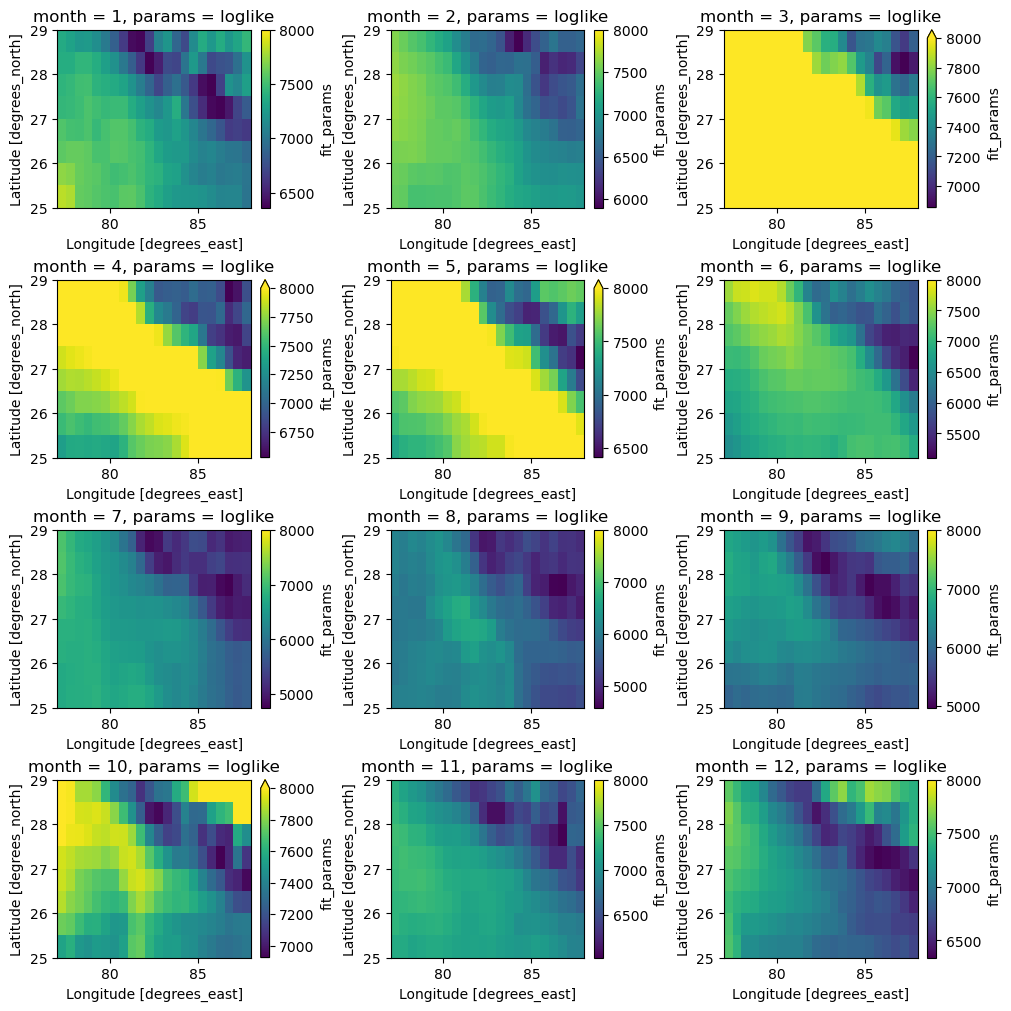

In [67]:
fig, axes = plt.subplots(4,3,layout='constrained',figsize=(10,10))
axes=axes.flatten()
for i in range(1,13):
    da_params.sel(params='loglike', month=i).astype('float32').plot(ax=axes[i-1],vmax=8000)

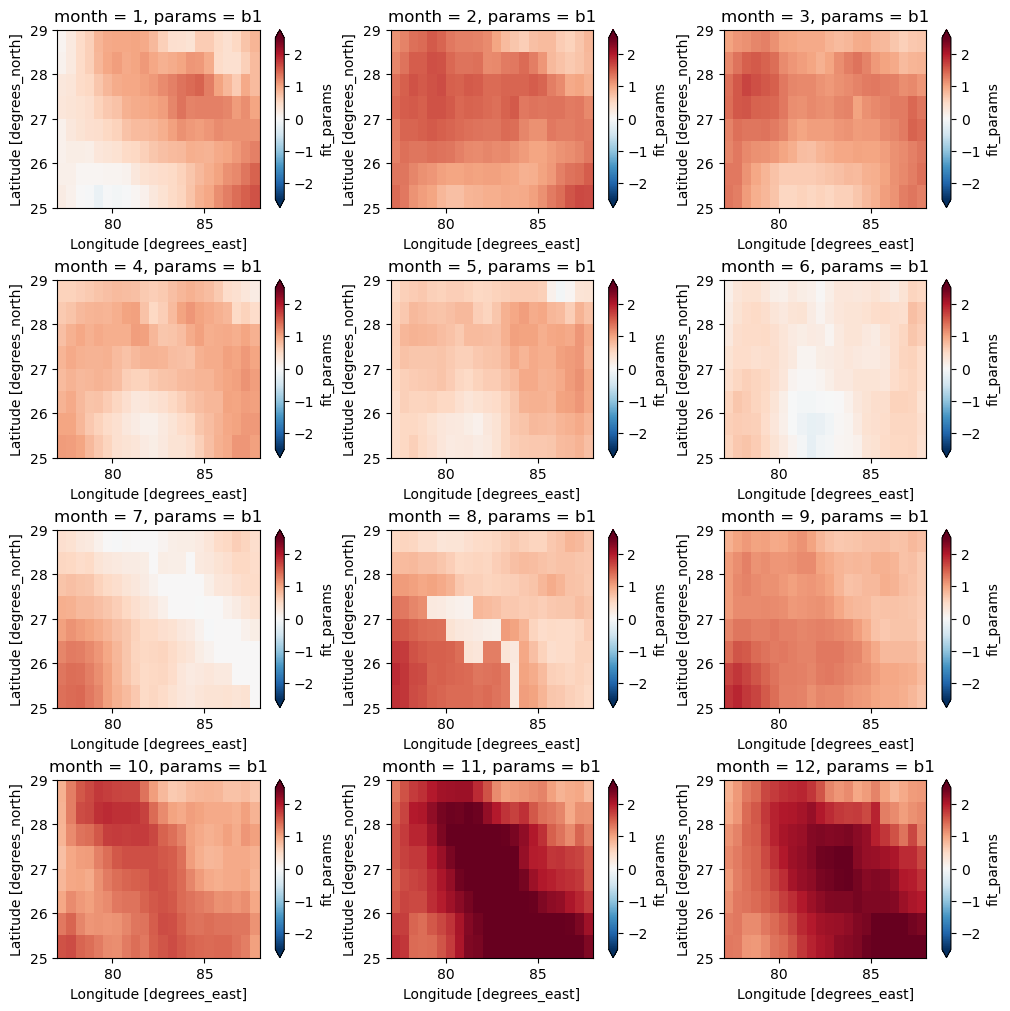

In [68]:
fig, axes = plt.subplots(4,3,layout='constrained',figsize=(10,10))
axes=axes.flatten()
for i in range(1,13):
    da_params.sel(params='b1', month=i).astype('float32').plot(ax=axes[i-1],cmap='RdBu_r',vmax=2.5,vmin=-2.5,extend='both')

In [69]:
da = da_sel
df_cov_smo = gmst_smo

da_params_loc = norm_shift_fit_loglike(da,
                                    df_cov_smo, 
                                    shift_sigma=False, 
                                    by_month=True)

test: dask parallelized


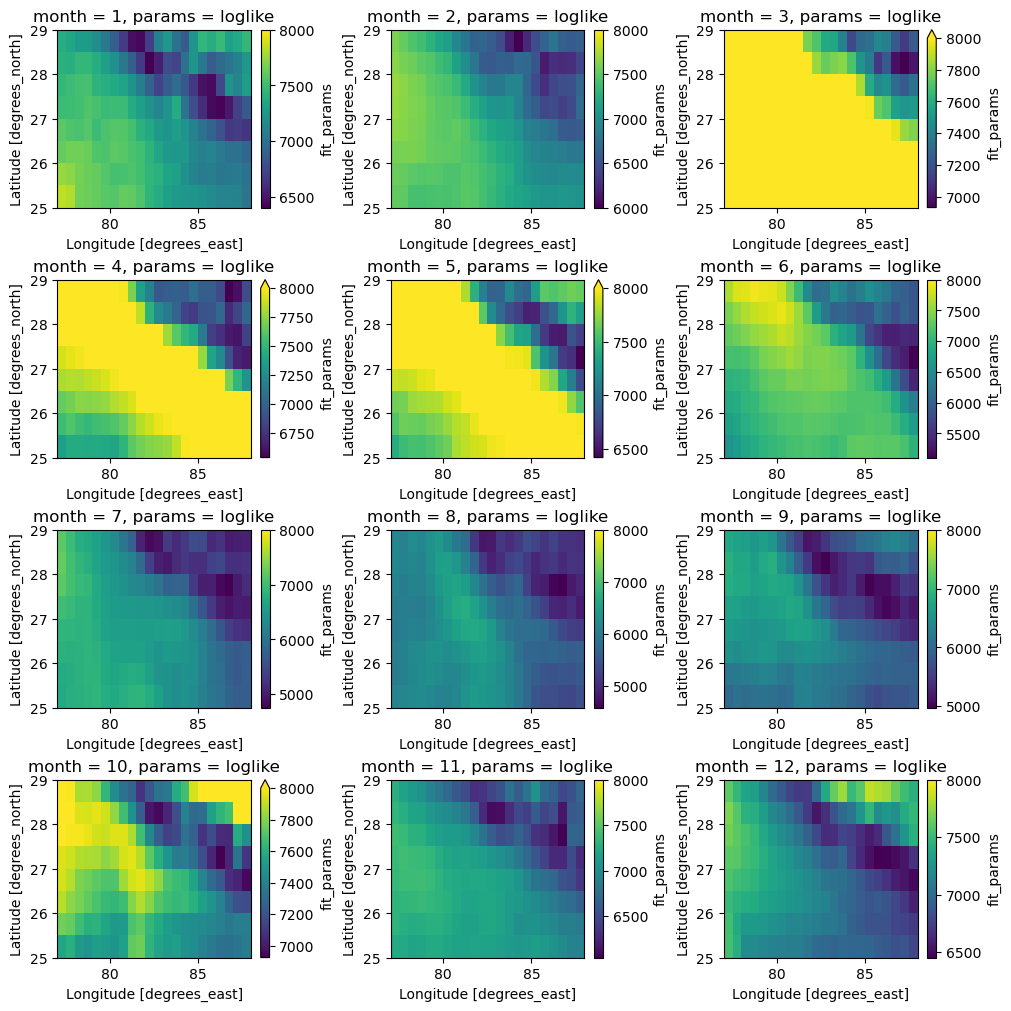

In [70]:
fig, axes = plt.subplots(4,3,layout='constrained',figsize=(10,10))
axes=axes.flatten()
for i in range(1,13):
    da_params_loc.sel(params='loglike', month=i).astype('float32').plot(ax=axes[i-1],vmax=8000)

Text(0.5, 0.98, 'Deviance statistic: D=2(LL_M1 - LL_M0) \nhigher values mean more improvement in M1')

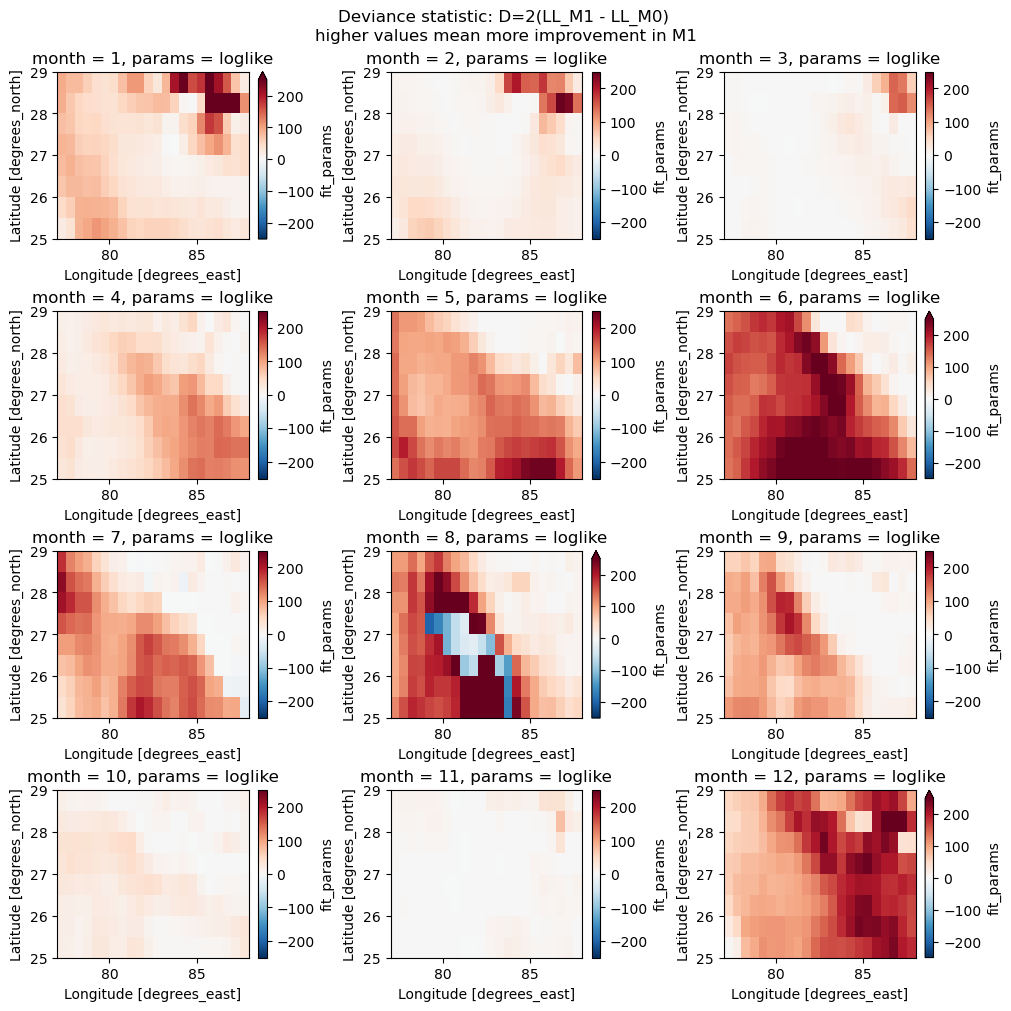

In [107]:
# compare more complex model minus less complex model

# Deviance statistic 
# D = 2(loglike_1 - loglike_0)

# note i computed the negative log likelihood ! 

fig, axes = plt.subplots(4,3,layout='constrained',figsize=(10,10))
axes=axes.flatten()
for i in range(1,13):
    dev_stat = 2 * (-da_params.sel(params='loglike', month=i).astype('float32') + da_params_loc.sel(params='loglike', month=i).astype('float32'))
    data_plot=dev_stat
    data_plot.plot(ax=axes[i-1],cmap='RdBu_r',vmax=250,vmin=-250)

fig.suptitle('Deviance statistic: D=2(LL_M1 - LL_M0) \nhigher values mean more improvement in M1')

Text(0.5, 0.98, 'p-value of improvement of including sigma shift \nhatched=no improvement')

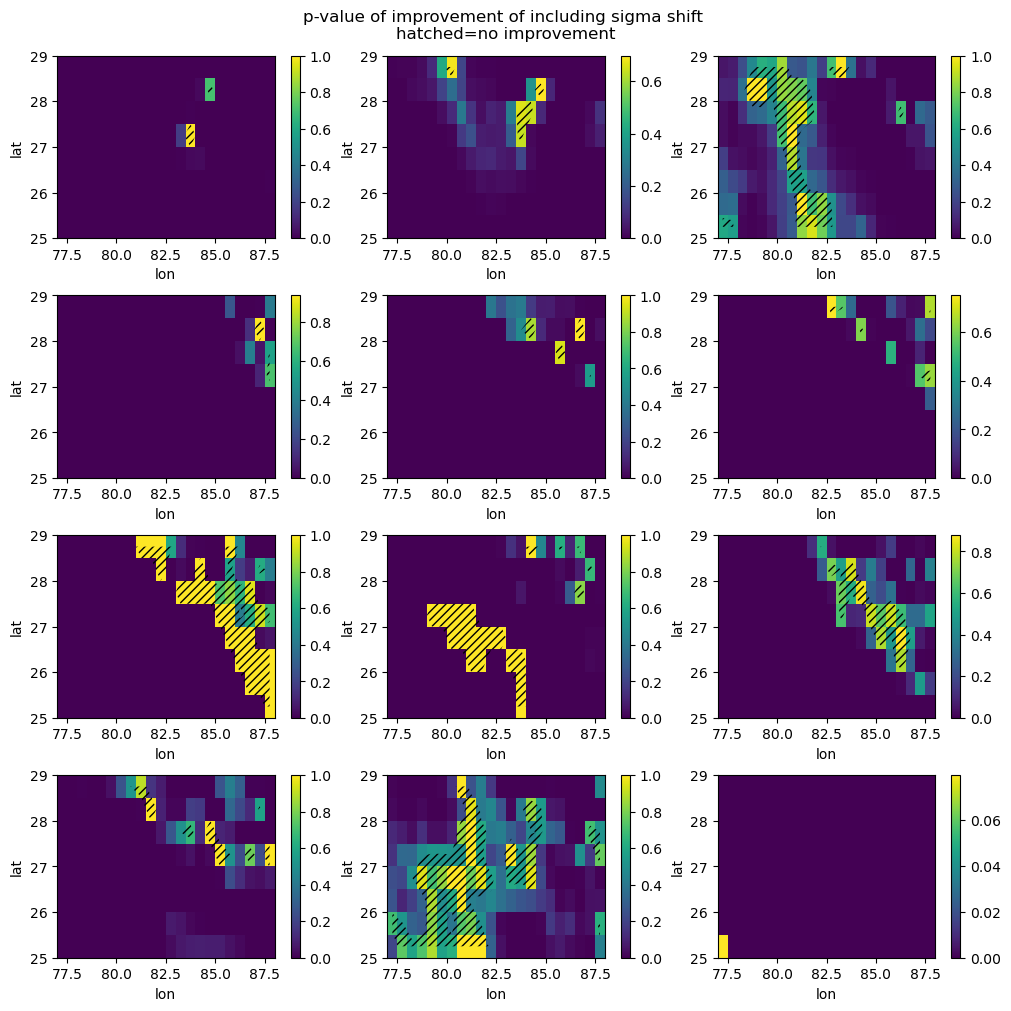

In [108]:
from scipy.stats import chi2

fig, axes = plt.subplots(4,3,layout='constrained',figsize=(10,10))
axes=axes.flatten()
for i in range(1,13):
    ax=axes[i-1]
    dev_stat = 2 * (-da_params.sel(params='loglike', month=i).astype('float32') + da_params_loc.sel(params='loglike', month=i).astype('float32'))
    p_val=1 - chi2.cdf(dev_stat, 1)
    p_val = xr.DataArray(p_val,
                dims=["lat", "lon"],
                coords=dict(
                    lon=(["lon"], dev_stat.lon.data),
                    lat=(["lat"], dev_stat.lat.data),
                ))
    #data_plot.plot(ax=ax)
    p_val.plot(ax=ax)
    ax.contourf(p_val.lon.values, p_val.lat.values, p_val.values,
             levels=[0.5,1], colors='none', hatches=['////'])
                 
fig.suptitle('p-value of improvement of including sigma shift \nhatched=no improvement')
